# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [8]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [9]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [10]:
import networkit as nk
import networkx as nx

# Setting

In [11]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", "2021-03-19 18-50")
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 100
    
    nodes_cnt = 200

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [12]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [42]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [43]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [44]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [45]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [46]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [47]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

## Read data

### Load test data

In [48]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [49]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [50]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [51]:
train_loader = to_dataloader(train, train_bet, batch=32)
valid_loader = to_dataloader(valid, valid_bet, batch=32)

In [68]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [69]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [52]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [53]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [54]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [55]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [56]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [57]:
import node2vec
from gensim.models import Word2Vec

In [58]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [59]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [60]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [61]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [63]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [64]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [65]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = torch.where(y_gt > 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))
            
#             y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]
                
                y_gt = torch.where(y_gt > 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

#                 y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]
                
                y_gt = torch.where(y_gt > 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

#                 y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 1/313 [00:00<00:41,  7.47it/s]


Epoch: 1


 25%|██▌       | 1/4 [00:00<00:00,  5.24it/s]

Train: loss = 0.3362124651158075, top 1 = 0.0018, top 5 = 0.48861000000000193, top 10 = 0.8220400000000416, kendal = 0.7953327094541646


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.3356773809473138, top 1 = 0.0, top 5 = 0.4639999999999999, top 10 = 0.8049999999999994, kendal = 0.7959855483619332

Epoch: 2


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

Train: loss = 0.21763346247819085, top 1 = 0.03355, top 5 = 0.7304499999999996, top 10 = 0.9064499999999496, kendal = 0.8575486330022372


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.21791559088245838, top 1 = 0.045, top 5 = 0.7230000000000001, top 10 = 0.9040000000000008, kendal = 0.8576167151510659

Epoch: 3


 25%|██▌       | 1/4 [00:00<00:00,  5.16it/s]

Train: loss = 0.1714300582424399, top 1 = 0.04625, top 5 = 0.8372699999999721, top 10 = 0.9406649999999539, kendal = 0.8843206058994229


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.17202897152420019, top 1 = 0.035, top 5 = 0.8399999999999995, top 10 = 0.935500000000001, kendal = 0.8831654623798039

Epoch: 4


 25%|██▌       | 1/4 [00:00<00:00,  5.18it/s]

Train: loss = 0.14817551920160116, top 1 = 0.09975, top 5 = 0.8870799999999229, top 10 = 0.9510899999999644, kendal = 0.8949975914730433


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.15194617630321766, top 1 = 0.115, top 5 = 0.8820000000000001, top 10 = 0.946500000000001, kendal = 0.8935473762710306

Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.13538792999739596, top 1 = 0.18985, top 5 = 0.9187199999999152, top 10 = 0.9628799999999823, kendal = 0.8986490982279943


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.13786031672266927, top 1 = 0.205, top 5 = 0.9080000000000001, top 10 = 0.9590000000000011, kendal = 0.8966649632511211

Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.12567973214836956, top 1 = 0.27105, top 5 = 0.9389399999999174, top 10 = 0.9669149999999858, kendal = 0.9032763849854218


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.12682227482490124, top 1 = 0.25, top 5 = 0.9340000000000005, top 10 = 0.960500000000001, kendal = 0.9013936092955198

Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.12010657910371053, top 1 = 0.35165, top 5 = 0.9500799999999248, top 10 = 0.9691799999999903, kendal = 0.9051092882193484


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.12391190531674834, top 1 = 0.35, top 5 = 0.9410000000000005, top 10 = 0.9640000000000011, kendal = 0.9028137099495488

Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.11598587386575944, top 1 = 0.36285, top 5 = 0.9562699999999313, top 10 = 0.9698899999999905, kendal = 0.9067980698950429


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11785310665810672, top 1 = 0.35, top 5 = 0.9510000000000002, top 10 = 0.9650000000000012, kendal = 0.9045202422340732

Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.11385167645858592, top 1 = 0.4786, top 5 = 0.9616499999999365, top 10 = 0.970519999999991, kendal = 0.9068600264787609


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1178062536708015, top 1 = 0.48, top 5 = 0.9570000000000004, top 10 = 0.966500000000001, kendal = 0.9044036569962389

Epoch: 10


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.11107046333317003, top 1 = 0.5024, top 5 = 0.9643099999999416, top 10 = 0.9710649999999912, kendal = 0.90855890088699


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1152233941000038, top 1 = 0.485, top 5 = 0.9640000000000003, top 10 = 0.967500000000001, kendal = 0.9060217507566223

Epoch: 11


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.11084992104775149, top 1 = 0.4957, top 5 = 0.9596199999999351, top 10 = 0.9689749999999904, kendal = 0.9069871598584621


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11516948312568179, top 1 = 0.5, top 5 = 0.9550000000000005, top 10 = 0.9665000000000012, kendal = 0.9042790336028801

Epoch: 12


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.1097367952222691, top 1 = 0.573, top 5 = 0.9641999999999401, top 10 = 0.9710599999999933, kendal = 0.9075753632131911


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1144707772295206, top 1 = 0.565, top 5 = 0.9640000000000003, top 10 = 0.968000000000001, kendal = 0.9047383294792242

Epoch: 13


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10732055572736897, top 1 = 0.6311, top 5 = 0.9692599999999467, top 10 = 0.9725649999999952, kendal = 0.909980541556442


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11081409666914695, top 1 = 0.62, top 5 = 0.9640000000000003, top 10 = 0.968500000000001, kendal = 0.907551397078613

Epoch: 14


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10598234676862973, top 1 = 0.7136, top 5 = 0.9731999999999532, top 10 = 0.9741549999999961, kendal = 0.9106731066825999


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11245672931542218, top 1 = 0.715, top 5 = 0.9680000000000004, top 10 = 0.9705000000000009, kendal = 0.9081855679076314

Epoch: 15


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10769633862686517, top 1 = 0.71065, top 5 = 0.9667799999999442, top 10 = 0.9704999999999935, kendal = 0.9083734367597713


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11084305405974067, top 1 = 0.71, top 5 = 0.9630000000000005, top 10 = 0.9685000000000009, kendal = 0.9054649627713167

Epoch: 16


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10559307962543706, top 1 = 0.83755, top 5 = 0.9736299999999541, top 10 = 0.9746049999999965, kendal = 0.9104005524477649


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1112274855142446, top 1 = 0.875, top 5 = 0.9730000000000004, top 10 = 0.9695000000000009, kendal = 0.9075564217244368

Epoch: 17


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10471129017411954, top 1 = 0.82315, top 5 = 0.9749199999999554, top 10 = 0.9744199999999968, kendal = 0.9111506552396309


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10777778761740868, top 1 = 0.85, top 5 = 0.9730000000000004, top 10 = 0.9690000000000011, kendal = 0.9084438590618832

Epoch: 18


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10497361909503332, top 1 = 0.8359, top 5 = 0.9737699999999537, top 10 = 0.9739899999999967, kendal = 0.910294536950716


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11053031866511016, top 1 = 0.865, top 5 = 0.9700000000000004, top 10 = 0.970000000000001, kendal = 0.9076187317165495

Epoch: 19


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10351494600652629, top 1 = 0.86075, top 5 = 0.9751399999999565, top 10 = 0.9749749999999967, kendal = 0.9117642733288227


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10889188477622123, top 1 = 0.9, top 5 = 0.9710000000000005, top 10 = 0.9715000000000009, kendal = 0.909056924514781

Epoch: 20


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10468685363376899, top 1 = 0.88705, top 5 = 0.9746699999999561, top 10 = 0.9750899999999976, kendal = 0.910536474315157


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11086729477030442, top 1 = 0.92, top 5 = 0.9740000000000003, top 10 = 0.969500000000001, kendal = 0.9077574273051249

Epoch: 21


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10550155098919708, top 1 = 0.8567, top 5 = 0.9700699999999488, top 10 = 0.9724449999999956, kendal = 0.909631047102459


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11131564928984561, top 1 = 0.885, top 5 = 0.9660000000000005, top 10 = 0.9670000000000009, kendal = 0.90679762795661

Epoch: 22


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10377289711101903, top 1 = 0.879, top 5 = 0.9742199999999553, top 10 = 0.9745449999999971, kendal = 0.9108985167926339


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11033847534476444, top 1 = 0.915, top 5 = 0.9730000000000004, top 10 = 0.9690000000000011, kendal = 0.9081564214466554

Epoch: 23


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10305212699291176, top 1 = 0.89895, top 5 = 0.9758999999999575, top 10 = 0.9753749999999974, kendal = 0.9118433735121881


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10729567909684472, top 1 = 0.93, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.9090860705212056

Epoch: 24


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10328692763283293, top 1 = 0.86295, top 5 = 0.973139999999953, top 10 = 0.9742149999999958, kendal = 0.9113910147754808


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10935264237878808, top 1 = 0.9, top 5 = 0.9680000000000004, top 10 = 0.9680000000000011, kendal = 0.9086307944928355

Epoch: 25


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10281757969561946, top 1 = 0.92165, top 5 = 0.9771399999999588, top 10 = 0.9752899999999972, kendal = 0.9120684922131748


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10642365381180109, top 1 = 0.935, top 5 = 0.9790000000000003, top 10 = 0.971000000000001, kendal = 0.9096297892656874

Epoch: 26


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10197406548642715, top 1 = 0.8903, top 5 = 0.9758899999999574, top 10 = 0.9753299999999959, kendal = 0.9127818157202159


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1059067909047419, top 1 = 0.93, top 5 = 0.9720000000000004, top 10 = 0.971000000000001, kendal = 0.9103333086718314

Epoch: 27


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10235149330748902, top 1 = 0.8942, top 5 = 0.9768999999999589, top 10 = 0.9751299999999965, kendal = 0.9121906128563396


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10842448134520327, top 1 = 0.9, top 5 = 0.9750000000000003, top 10 = 0.9690000000000011, kendal = 0.9098549169140547

Epoch: 28


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10240685158497997, top 1 = 0.9266, top 5 = 0.9771699999999593, top 10 = 0.9755249999999971, kendal = 0.9120923305095024


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10919613608490972, top 1 = 0.94, top 5 = 0.9750000000000004, top 10 = 0.9710000000000008, kendal = 0.9093915991442568

Epoch: 29


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10204034815362542, top 1 = 0.92565, top 5 = 0.9771499999999597, top 10 = 0.9756949999999973, kendal = 0.9122332606387524


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10663696138908081, top 1 = 0.94, top 5 = 0.9750000000000003, top 10 = 0.9705000000000009, kendal = 0.9093875786649618

Epoch: 30


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10094219072915162, top 1 = 0.929, top 5 = 0.9779399999999605, top 10 = 0.9755199999999977, kendal = 0.9133933565908429


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10633975517425423, top 1 = 0.945, top 5 = 0.9790000000000003, top 10 = 0.972500000000001, kendal = 0.9110117022730647

Epoch: 31


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10108861682630364, top 1 = 0.93365, top 5 = 0.9778199999999603, top 10 = 0.9752449999999963, kendal = 0.9134327234457247


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10596440524034678, top 1 = 0.945, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.9110860751929806

Epoch: 32


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10196868974954425, top 1 = 0.93195, top 5 = 0.9760699999999582, top 10 = 0.9752949999999968, kendal = 0.9123150194206028


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10975623253842609, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.9096117011366874

Epoch: 33


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10250565619991588, top 1 = 0.9225, top 5 = 0.9746499999999558, top 10 = 0.974134999999997, kendal = 0.9119361698332638


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10870971900211314, top 1 = 0.94, top 5 = 0.9750000000000003, top 10 = 0.9705000000000011, kendal = 0.9093393402872494

Epoch: 34


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10093675864153026, top 1 = 0.93225, top 5 = 0.97791999999996, top 10 = 0.9754699999999957, kendal = 0.9133979186042563


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10697746140198713, top 1 = 0.935, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.9111654724556861

Epoch: 35


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10089211612139648, top 1 = 0.92075, top 5 = 0.9770799999999595, top 10 = 0.9756549999999963, kendal = 0.9133107884082645


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10906572183746002, top 1 = 0.93, top 5 = 0.9750000000000003, top 10 = 0.9720000000000009, kendal = 0.9107011497870268

Epoch: 36


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10019656392373565, top 1 = 0.94005, top 5 = 0.9787499999999618, top 10 = 0.9758649999999974, kendal = 0.9139457130811274


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10612105911774652, top 1 = 0.935, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.911510195492962

Epoch: 37


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10030921640815661, top 1 = 0.93655, top 5 = 0.9770599999999593, top 10 = 0.9756599999999982, kendal = 0.9136290519384939


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1075290062389575, top 1 = 0.93, top 5 = 0.9770000000000003, top 10 = 0.9715000000000009, kendal = 0.9109252706930759

Epoch: 38


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10174271042014986, top 1 = 0.93995, top 5 = 0.9771099999999596, top 10 = 0.9744899999999956, kendal = 0.9125746252421609


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10852504630976087, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.971000000000001, kendal = 0.9101162258962436

Epoch: 39


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10018414596788448, top 1 = 0.9421, top 5 = 0.9782699999999617, top 10 = 0.9761949999999975, kendal = 0.9139530173055009


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1060397214473088, top 1 = 0.945, top 5 = 0.9780000000000002, top 10 = 0.9745000000000009, kendal = 0.9114086886623525

Epoch: 40


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10020571156493116, top 1 = 0.9463, top 5 = 0.9785699999999619, top 10 = 0.9761599999999983, kendal = 0.9140441319509067


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10407390269293565, top 1 = 0.935, top 5 = 0.9790000000000003, top 10 = 0.9710000000000008, kendal = 0.9114247690896151

Epoch: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10007732525284076, top 1 = 0.94265, top 5 = 0.9785799999999617, top 10 = 0.9758699999999976, kendal = 0.9143168232172778


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.107044904298242, top 1 = 0.935, top 5 = 0.9750000000000003, top 10 = 0.9715000000000008, kendal = 0.9119353229898124

Epoch: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10236686279185904, top 1 = 0.94435, top 5 = 0.9763999999999587, top 10 = 0.974829999999997, kendal = 0.9119348664378393


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.11026559084299536, top 1 = 0.955, top 5 = 0.9770000000000003, top 10 = 0.968500000000001, kendal = 0.9092257745187861

Epoch: 43


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09975954742764971, top 1 = 0.9425, top 5 = 0.9785599999999622, top 10 = 0.975714999999998, kendal = 0.9143867706928255


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1055895354973913, top 1 = 0.935, top 5 = 0.9790000000000003, top 10 = 0.9720000000000009, kendal = 0.9120026596732292

Epoch: 44


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10047461268985272, top 1 = 0.94965, top 5 = 0.9782899999999614, top 10 = 0.9752399999999961, kendal = 0.9137663562007445


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10865918740096937, top 1 = 0.94, top 5 = 0.9780000000000004, top 10 = 0.9715000000000009, kendal = 0.9114911022125718

Epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09905701926988465, top 1 = 0.949, top 5 = 0.9791199999999628, top 10 = 0.9758749999999982, kendal = 0.9146935266921835


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1079906643690173, top 1 = 0.935, top 5 = 0.9800000000000004, top 10 = 0.9740000000000008, kendal = 0.9122398464867268

Epoch: 46


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09928715293493845, top 1 = 0.95485, top 5 = 0.9790199999999626, top 10 = 0.9761049999999979, kendal = 0.9148671402104952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10717979188692268, top 1 = 0.95, top 5 = 0.9770000000000003, top 10 = 0.9730000000000009, kendal = 0.9124850726426337

Epoch: 47


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10011519724424267, top 1 = 0.93625, top 5 = 0.979289999999963, top 10 = 0.9760999999999989, kendal = 0.9139709894284417


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10830168161869504, top 1 = 0.915, top 5 = 0.9790000000000003, top 10 = 0.9740000000000009, kendal = 0.9118046719709837

Epoch: 48


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09979095236081079, top 1 = 0.9553, top 5 = 0.9792899999999621, top 10 = 0.9760749999999969, kendal = 0.9143939844005301


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10699351275419083, top 1 = 0.935, top 5 = 0.9790000000000003, top 10 = 0.973000000000001, kendal = 0.911869996785945

Epoch: 49


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10024071212010313, top 1 = 0.9564, top 5 = 0.9786799999999619, top 10 = 0.9752499999999967, kendal = 0.9138994595024101


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10670809547138842, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.9115252724355223

Epoch: 50


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.0997795801369484, top 1 = 0.94925, top 5 = 0.9790799999999626, top 10 = 0.9760849999999982, kendal = 0.9143882659050502


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10764873482677531, top 1 = 0.935, top 5 = 0.9780000000000004, top 10 = 0.9730000000000009, kendal = 0.9122529130002442

Epoch: 51


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09897505211727171, top 1 = 0.95775, top 5 = 0.9792599999999624, top 10 = 0.9763399999999977, kendal = 0.9149106176595496


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1072905491414, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9755000000000008, kendal = 0.912458943201503

Epoch: 52


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09916688419952727, top 1 = 0.94465, top 5 = 0.9788499999999624, top 10 = 0.9761549999999972, kendal = 0.9148443987600403


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10633743206507365, top 1 = 0.92, top 5 = 0.9770000000000002, top 10 = 0.9740000000000009, kendal = 0.9125674859655772

Epoch: 53


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09882512284704323, top 1 = 0.9494, top 5 = 0.9790699999999625, top 10 = 0.9761099999999966, kendal = 0.9152975925425055


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10655804173282592, top 1 = 0.935, top 5 = 0.9780000000000004, top 10 = 0.976000000000001, kendal = 0.9128247729785528

Epoch: 54


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09936142819708484, top 1 = 0.95445, top 5 = 0.9795099999999626, top 10 = 0.9763749999999977, kendal = 0.9149547953730406


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10866346247822807, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9730000000000009, kendal = 0.9124830632489562

Epoch: 55


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09930346896383933, top 1 = 0.9433, top 5 = 0.9771899999999598, top 10 = 0.9757399999999979, kendal = 0.9146707930511153


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10540460903961256, top 1 = 0.925, top 5 = 0.9740000000000003, top 10 = 0.9740000000000009, kendal = 0.9121393461206557

Epoch: 56


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.0989407735703464, top 1 = 0.95285, top 5 = 0.9792299999999624, top 10 = 0.9762449999999977, kendal = 0.914992248046426


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10470757158070969, top 1 = 0.95, top 5 = 0.9830000000000004, top 10 = 0.9750000000000008, kendal = 0.9127353256161074

Epoch: 57


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09844719759174676, top 1 = 0.94925, top 5 = 0.9801799999999643, top 10 = 0.9765499999999975, kendal = 0.9154386323132608


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10727878957051824, top 1 = 0.93, top 5 = 0.9790000000000003, top 10 = 0.9745000000000009, kendal = 0.9131061796096828

Epoch: 58


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09874023253780169, top 1 = 0.95265, top 5 = 0.9792199999999626, top 10 = 0.9758199999999971, kendal = 0.9152554896963458


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10468662795303751, top 1 = 0.935, top 5 = 0.9780000000000004, top 10 = 0.9750000000000009, kendal = 0.9127152256186519

Epoch: 59


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09967303011543144, top 1 = 0.96125, top 5 = 0.9786999999999625, top 10 = 0.9755699999999983, kendal = 0.9143485272317865


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10692932242484895, top 1 = 0.96, top 5 = 0.9780000000000001, top 10 = 0.9745000000000009, kendal = 0.9117122098109427

Epoch: 60


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09876839535545244, top 1 = 0.95265, top 5 = 0.978379999999961, top 10 = 0.975889999999997, kendal = 0.9152073133877034


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10775648652151743, top 1 = 0.96, top 5 = 0.9770000000000004, top 10 = 0.9745000000000009, kendal = 0.9127805521003012

Epoch: 61


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09802188481053634, top 1 = 0.9582, top 5 = 0.9799599999999642, top 10 = 0.9764149999999987, kendal = 0.9157862983585409


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10297194176396189, top 1 = 0.945, top 5 = 0.9770000000000003, top 10 = 0.9755000000000009, kendal = 0.9132257782309542

Epoch: 62


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.099742710981954, top 1 = 0.9542, top 5 = 0.9779499999999611, top 10 = 0.9757449999999983, kendal = 0.9142810799046922


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10800626627713598, top 1 = 0.965, top 5 = 0.9790000000000003, top 10 = 0.9760000000000008, kendal = 0.9116669829479567

Epoch: 63


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09797154685962003, top 1 = 0.95165, top 5 = 0.9796099999999631, top 10 = 0.9765799999999968, kendal = 0.9158908063297655


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10320832667020376, top 1 = 0.93, top 5 = 0.9720000000000004, top 10 = 0.9760000000000008, kendal = 0.9133463814227994

Epoch: 64


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09848412163846051, top 1 = 0.95515, top 5 = 0.9779499999999607, top 10 = 0.9758699999999966, kendal = 0.9154400748692084


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10435458205070361, top 1 = 0.93, top 5 = 0.9760000000000004, top 10 = 0.972500000000001, kendal = 0.9129986424515508

Epoch: 65


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.10042663347144773, top 1 = 0.9544, top 5 = 0.9769999999999595, top 10 = 0.9741149999999968, kendal = 0.9138312677078335


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10674890122334867, top 1 = 0.96, top 5 = 0.9740000000000003, top 10 = 0.9730000000000009, kendal = 0.9113333150860524

Epoch: 66


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09805041132675087, top 1 = 0.95475, top 5 = 0.979939999999964, top 10 = 0.9764499999999982, kendal = 0.9156870822397563


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10541768397193545, top 1 = 0.94, top 5 = 0.9800000000000003, top 10 = 0.9755000000000008, kendal = 0.9132549237323212

Epoch: 67


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.0991775337133023, top 1 = 0.95855, top 5 = 0.9762799999999588, top 10 = 0.9738849999999946, kendal = 0.914838053997591


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10281623762055339, top 1 = 0.965, top 5 = 0.9770000000000004, top 10 = 0.9715000000000009, kendal = 0.912315224861067

Epoch: 68


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09769380068852776, top 1 = 0.95575, top 5 = 0.979579999999963, top 10 = 0.9768599999999986, kendal = 0.916005381475109


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10433601108651684, top 1 = 0.95, top 5 = 0.9760000000000002, top 10 = 0.9760000000000008, kendal = 0.9136016586633054

Epoch: 69


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09784079812188726, top 1 = 0.9586, top 5 = 0.9795799999999639, top 10 = 0.9766499999999989, kendal = 0.9158692230139795


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10623133395507542, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9765000000000008, kendal = 0.913442864743962

Epoch: 70


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09765937854013311, top 1 = 0.96715, top 5 = 0.9790799999999623, top 10 = 0.9764099999999982, kendal = 0.9160442101787069


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1061407210550649, top 1 = 0.955, top 5 = 0.9770000000000003, top 10 = 0.9775000000000007, kendal = 0.9136177383582358

Epoch: 71


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09804372640363497, top 1 = 0.96215, top 5 = 0.979519999999963, top 10 = 0.9764149999999984, kendal = 0.915762662494317


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.105676567008712, top 1 = 0.95, top 5 = 0.9740000000000005, top 10 = 0.9755000000000008, kendal = 0.9135303028894997

Epoch: 72


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09755420378260804, top 1 = 0.9606, top 5 = 0.9795599999999632, top 10 = 0.9766049999999981, kendal = 0.9161395176077421


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10677887351792253, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9755000000000008, kendal = 0.9138408552240207

Epoch: 73


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09832931070910711, top 1 = 0.96375, top 5 = 0.9787099999999619, top 10 = 0.9754899999999971, kendal = 0.9156549748507424


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10561653361935582, top 1 = 0.97, top 5 = 0.9770000000000004, top 10 = 0.9720000000000009, kendal = 0.9132197473478678

Epoch: 74


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09753340940456794, top 1 = 0.9617, top 5 = 0.9801299999999641, top 10 = 0.9768149999999981, kendal = 0.9163087058045248


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10414331535036023, top 1 = 0.965, top 5 = 0.9750000000000003, top 10 = 0.9735000000000009, kendal = 0.9139594474312587

Epoch: 75


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09870568540773685, top 1 = 0.96075, top 5 = 0.9788199999999624, top 10 = 0.9758999999999977, kendal = 0.9152299744684688


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10467459720839667, top 1 = 0.97, top 5 = 0.9760000000000004, top 10 = 0.9725000000000008, kendal = 0.9127212555673827

Epoch: 76


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.0974292779465414, top 1 = 0.96605, top 5 = 0.9792399999999621, top 10 = 0.9768899999999979, kendal = 0.9163140424894611


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1047541478722599, top 1 = 0.97, top 5 = 0.9790000000000003, top 10 = 0.9755000000000008, kendal = 0.913791608588819

Epoch: 77


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09764254045749969, top 1 = 0.95845, top 5 = 0.9797599999999625, top 10 = 0.9768149999999987, kendal = 0.9162365651111071


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10560477072501558, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9755000000000008, kendal = 0.9138267846197327

Epoch: 78


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09813656497120142, top 1 = 0.9611, top 5 = 0.9784099999999615, top 10 = 0.9762449999999988, kendal = 0.9157666253504971


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10590013776891247, top 1 = 0.97, top 5 = 0.9780000000000004, top 10 = 0.9730000000000009, kendal = 0.9132669845388857

Epoch: 79


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09733527614686091, top 1 = 0.9612, top 5 = 0.9788599999999622, top 10 = 0.9769999999999996, kendal = 0.9164949045207044


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10483439306255797, top 1 = 0.955, top 5 = 0.9770000000000003, top 10 = 0.976000000000001, kendal = 0.9141001508225831

Epoch: 80


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09745337170717185, top 1 = 0.96565, top 5 = 0.9801699999999642, top 10 = 0.976534999999998, kendal = 0.9162153312278946


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.104294538291048, top 1 = 0.96, top 5 = 0.9760000000000004, top 10 = 0.9760000000000008, kendal = 0.9136689959022842

Epoch: 81


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09711825913397588, top 1 = 0.962, top 5 = 0.980349999999964, top 10 = 0.9771099999999988, kendal = 0.916684235804292


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10292671539581515, top 1 = 0.94, top 5 = 0.9760000000000004, top 10 = 0.9755000000000008, kendal = 0.9142006543957648

Epoch: 82


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09735829114460438, top 1 = 0.9629, top 5 = 0.980209999999964, top 10 = 0.9769099999999998, kendal = 0.9163395322311452


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10402602167523513, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.9750000000000009, kendal = 0.9137855786653407

Epoch: 83


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09710535611331161, top 1 = 0.9661, top 5 = 0.9804399999999645, top 10 = 0.9771799999999977, kendal = 0.9166373768640805


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10147890536362832, top 1 = 0.96, top 5 = 0.9760000000000004, top 10 = 0.976000000000001, kendal = 0.9141725132376964

Epoch: 84


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09764059165810096, top 1 = 0.9644, top 5 = 0.9794199999999635, top 10 = 0.9769799999999991, kendal = 0.9162451997752292


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10190762985062303, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9755000000000008, kendal = 0.9136649755997598

Epoch: 85


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09745337810140504, top 1 = 0.96345, top 5 = 0.9786299999999617, top 10 = 0.9769599999999982, kendal = 0.9161372732574113


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10498326529057987, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.976000000000001, kendal = 0.913804673789188

Epoch: 86


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.0974509297991054, top 1 = 0.96945, top 5 = 0.9803099999999644, top 10 = 0.9768899999999993, kendal = 0.9162887112217722


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10354216791035611, top 1 = 0.96, top 5 = 0.9740000000000003, top 10 = 0.9765000000000008, kendal = 0.9136569355250187

Epoch: 87


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09737530351707609, top 1 = 0.9671, top 5 = 0.9793499999999623, top 10 = 0.9769549999999996, kendal = 0.9165433034129626


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10347643217742901, top 1 = 0.96, top 5 = 0.9770000000000004, top 10 = 0.9735000000000009, kendal = 0.9141514068514616

Epoch: 88


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09757958393594214, top 1 = 0.96375, top 5 = 0.9800499999999632, top 10 = 0.9769799999999992, kendal = 0.9163519969032726


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10374035505439147, top 1 = 0.955, top 5 = 0.9750000000000004, top 10 = 0.9760000000000008, kendal = 0.9138127142932265

Epoch: 89


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09687424436768086, top 1 = 0.96875, top 5 = 0.9803199999999644, top 10 = 0.9770400000000001, kendal = 0.9168221198345351


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10380608672447375, top 1 = 0.965, top 5 = 0.9750000000000003, top 10 = 0.9750000000000009, kendal = 0.914324272359953

Epoch: 90


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09821686793649438, top 1 = 0.9616, top 5 = 0.9781799999999615, top 10 = 0.9762149999999985, kendal = 0.9155758182277548


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10445249041463203, top 1 = 0.97, top 5 = 0.9760000000000004, top 10 = 0.974500000000001, kendal = 0.9129081902912551

Epoch: 91


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09708547454628975, top 1 = 0.96775, top 5 = 0.9796599999999637, top 10 = 0.9772349999999996, kendal = 0.9168671225427814


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10359110908623023, top 1 = 0.965, top 5 = 0.9770000000000004, top 10 = 0.9765000000000009, kendal = 0.9143544228106875

Epoch: 92


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09704820272231028, top 1 = 0.96255, top 5 = 0.9793799999999623, top 10 = 0.9769399999999998, kendal = 0.916742310723141


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10404818788986096, top 1 = 0.96, top 5 = 0.9730000000000004, top 10 = 0.9745000000000009, kendal = 0.9145051768320607

Epoch: 93


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09751312691435153, top 1 = 0.96785, top 5 = 0.9802499999999642, top 10 = 0.9764699999999988, kendal = 0.9160734952340516


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10366745700257686, top 1 = 0.96, top 5 = 0.9750000000000004, top 10 = 0.9765000000000009, kendal = 0.9136951261515062

Epoch: 94


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09807476751642166, top 1 = 0.96945, top 5 = 0.980209999999964, top 10 = 0.9770699999999982, kendal = 0.9154069470236899


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1033099489797311, top 1 = 0.96, top 5 = 0.9760000000000002, top 10 = 0.9755000000000008, kendal = 0.9130639710796906

Epoch: 95


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09785628355272885, top 1 = 0.96465, top 5 = 0.9794799999999632, top 10 = 0.9763999999999993, kendal = 0.91590206720453


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10278814044363789, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.9755000000000008, kendal = 0.9132388452495277

Epoch: 96


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09675282069482351, top 1 = 0.9647, top 5 = 0.980329999999964, top 10 = 0.9771699999999988, kendal = 0.917013351331679


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10323996810718153, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.9780000000000009, kendal = 0.9144951268838384

Epoch: 97


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09695819840312199, top 1 = 0.9693, top 5 = 0.9793199999999616, top 10 = 0.9767499999999991, kendal = 0.9165834518448029


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.1039756127909034, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9770000000000008, kendal = 0.9140187454540946

Epoch: 98


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09735929046359895, top 1 = 0.96695, top 5 = 0.9792499999999622, top 10 = 0.9768849999999989, kendal = 0.9163939374178364


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10134271236061691, top 1 = 0.96, top 5 = 0.9760000000000002, top 10 = 0.9775000000000008, kendal = 0.9139423636455574

Epoch: 99


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09661784287083489, top 1 = 0.96975, top 5 = 0.9802099999999642, top 10 = 0.9768299999999992, kendal = 0.9168257936046048


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.10043936553100631, top 1 = 0.96, top 5 = 0.9750000000000003, top 10 = 0.976000000000001, kendal = 0.9143815584385742

Epoch: 100


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.09683059335717445, top 1 = 0.97015, top 5 = 0.9804399999999645, top 10 = 0.9774799999999998, kendal = 0.9168816753654457


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

Valid: loss = 0.10255117590230156, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.976000000000001, kendal = 0.9142810556482298


# Test

In [73]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = torch.where(y_gt > 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

#             y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [74]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 30/30 [00:11<00:00,  2.53it/s]

Top1: mean=0.88, std=0.03
Top5: mean=0.90, std=0.02
Top10: mean=0.87, std=0.02
Kendal: mean=0.71, std=0.01
Time: mean=0.38, std=0.11
Loss: mean=0.59, std=0.02


In [75]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:29<00:00, 89.48s/it]

Top1: mean=0.63, std=0.00
Top5: mean=0.69, std=0.00
Top10: mean=0.71, std=0.00
Kendal: mean=0.48, std=0.00
Time: mean=88.69, std=0.00
Loss: mean=1.20, std=0.00


# Visualization

In [13]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-19 18-50'

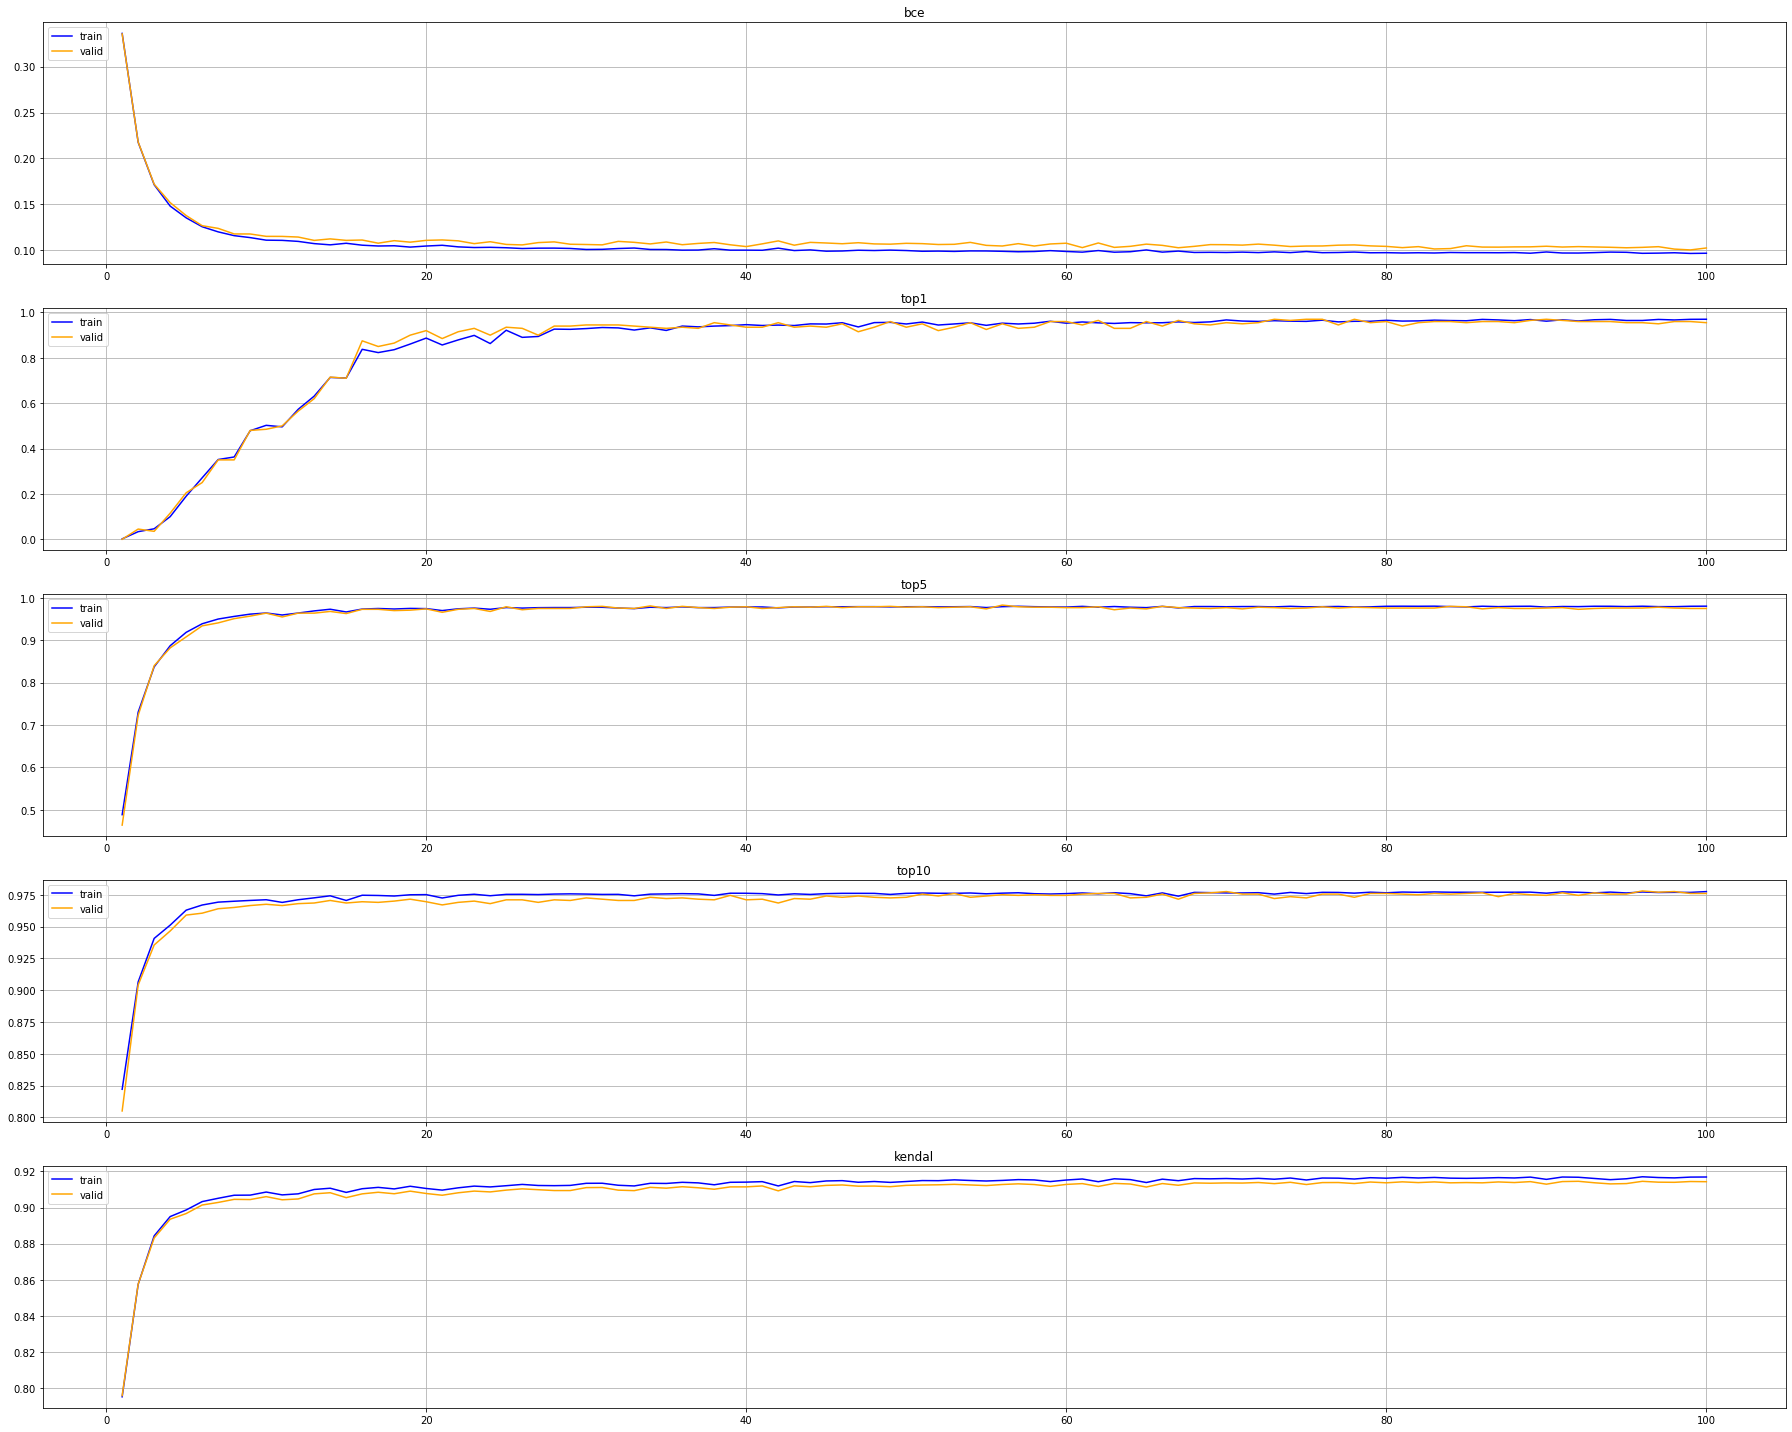

In [14]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]

        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [33]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

weight: 3000.pth
pretrained finded
weight: 300.pth
pretrained finded
weight: 1200.pth
pretrained finded
weight: 5000.pth
pretrained finded
weight: 200.pth
pretrained finded



top1
scale=200, mean=0.6606666666666666, std=0.16374641641541007
scale=300, mean=0.6593333333333333, std=0.16301192867053899
scale=1200, mean=0.66, std=0.16403251710153893
scale=3000, mean=0.6833333333333336, std=0.17220788470785986
scale=5000, mean=0.636, std=0.1423985018647785

top5
scale=200, mean=0.6389333333333334, std=0.1302343869934341
scale=300, mean=0.6376000000000002, std=0.12988856762625414
scale=1200, mean=0.6573333333333333, std=0.13822236513032984
scale=3000, mean=0.6728, std=0.15371454062644824
scale=5000, mean=0.6188, std=0.12861166354572975

top10
scale=200, mean=0.6447333333333333, std=0.11378047088826604
scale=300, mean=0.6474000000000001, std=0.11626423927129671
scale=1200, mean=0.6700666666666667, std=0.12222763826383769
scale=3000, mean=0.6585333333333332, std=0.13130314373828053
scale=5000, mean=0.6415333333333334, std=0.11461783844100747

kendal
scale=200, mean=0.4162531066213242, std=0.11592136297554113
scale=300, mean=0.34002063879442557, std=0.10374069606698

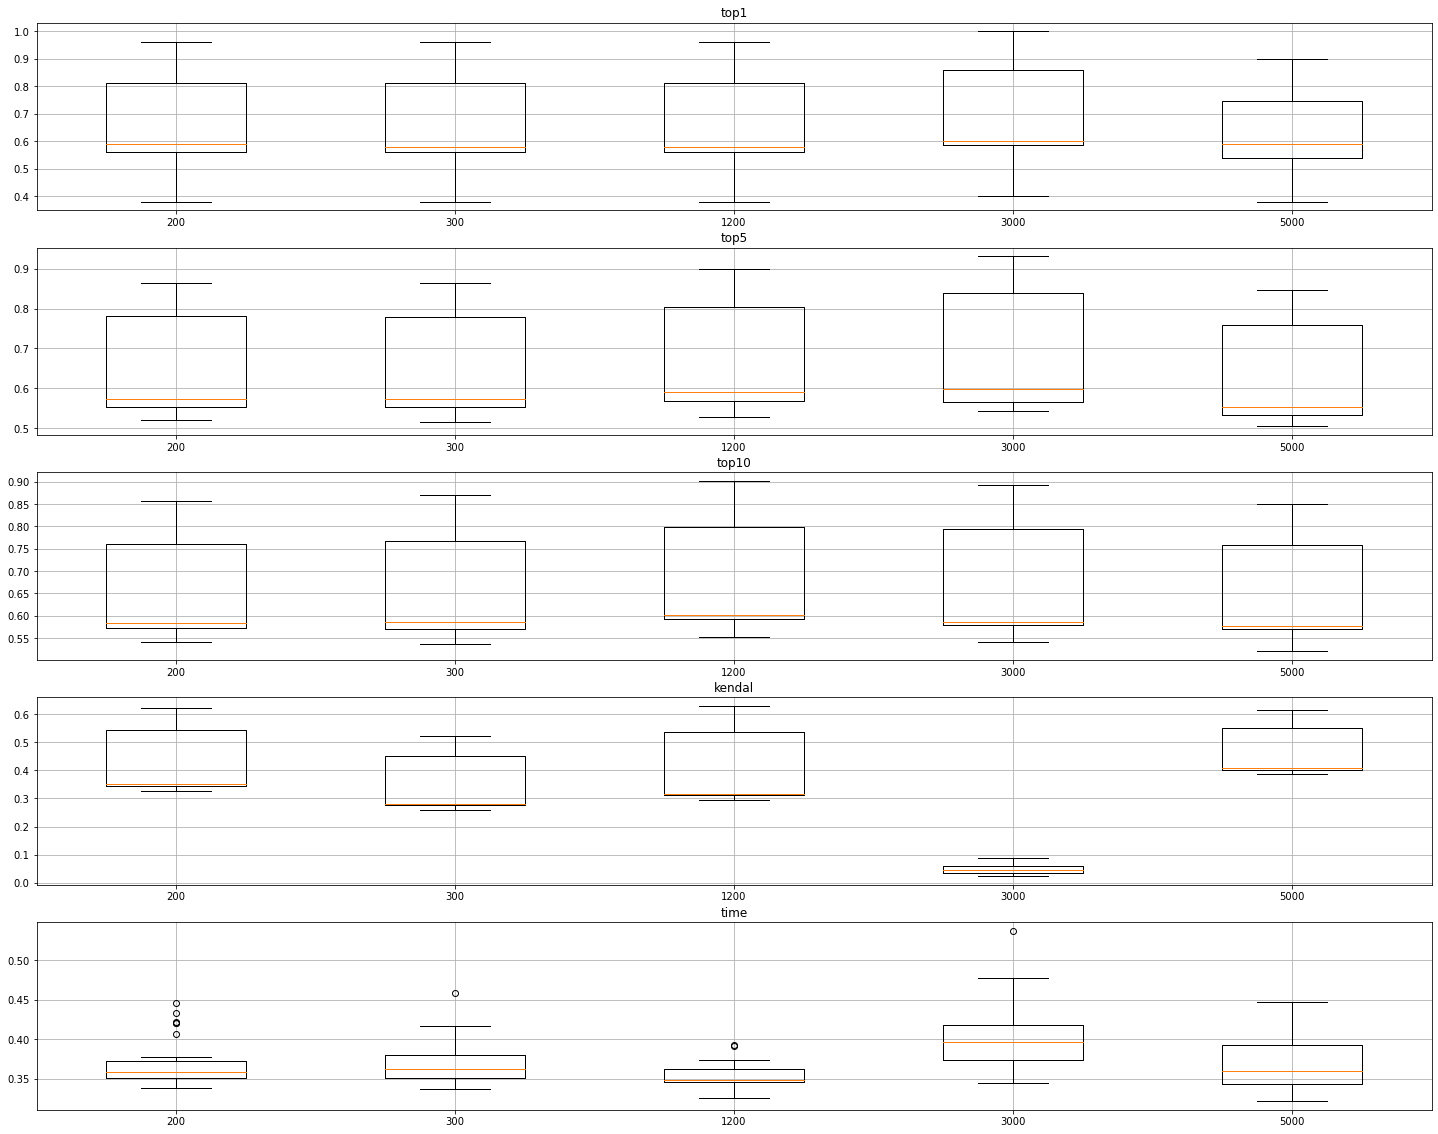

In [37]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    